In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import correlate, correlation_lags
import torch
import tqdm

from sparks.models.sparks import SPARKS
from sparks.models.dataclasses import HebbianAttentionConfig, AttentionConfig
from sparks.data.mec import make_mec_ca_dataset

# MEC slow oscillatory sequences 

Can we gain insights into neural data using SPARKS?
Let us examine a calcium recording from the medial entorhinal cortex (`[Gonzalo Cogno, ..., Moser, Nature 2023]`), starting by having a look at the data. When plotting this data in no particular order, their spike trains seem somewhat random.

In [2]:
data_path = os.path.join(os.getcwd(), 'calcium_activity_matrix_60584_session17.mat') # path to where the data is located.
# by default where the notebook is located, if the data isn't found it will be downloaded from 
# https://github.com/soledadgcogno/Ultraslow-oscillatory-sequences/blob/main/Selection%20of%20codes/calcium_activity_matrix_60584_session17.mat
if not os.path.exists(data_path):
    import urllib.request
    urllib.request.urlretrieve("https://github.com/soledadgcogno/Ultraslow-oscillatory-sequences/raw/main/Selection%20of%20codes/calcium_activity_matrix_60584_session17.mat", 
                               "calcium_activity_matrix_60584_session17.mat")
session_data = loadmat(data_path) # spikes saved in a matlab sparse matrix
spikes_idxs = session_data['spikes_d_s'].nonzero() # obtain the spike indices 
spikes = np.zeros(session_data['spikes_d_s'].shape) # reconstruct the histogram
spikes[spikes_idxs[0], spikes_idxs[1]] = 1
fs_120 = 7.73 # sampling rate

Text(0, 0.5, 'Neurons')

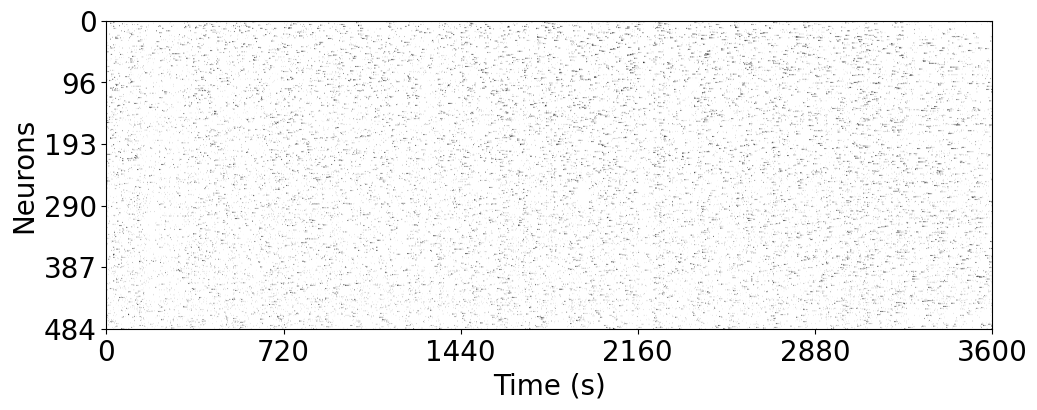

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.imshow(np.repeat(spikes, 20, 0), cmap='Greys')

T = spikes.shape[-1] / fs_120
ax.set_xticks(np.arange(0, int(spikes.shape[-1] + spikes.shape[-1] / 5), spikes.shape[-1] / 5))
ax.set_xticklabels(np.arange(0, T + T / 5, T / 5).astype(int), fontsize=20)
ax.set_xlabel('Time (s)', fontsize=20)

ax.set_yticks(np.arange(0, 20 * spikes.shape[0] + 20 * spikes.shape[0] / 5,
                        20 * spikes.shape[0] / 5))
ax.set_yticklabels(np.arange(0, spikes.shape[0] + spikes.shape[0] / 5, 
                             spikes.shape[0] / 5).astype(int), fontsize=20)
ax.set_ylabel('Neurons', fontsize=20)

Can SPARKS be applied to this data to gain insights into it?

## Create dataloader
To apply SPARKS, the data should be fed through Pytorch dataloaders. More details on these can be found directly from the Pytorch website, and we give an example in the `demo_monkey` notebook.

In [4]:
start_stop_times_train = np.array([(600 + i * 500, 600 + (i + 1) * 500) for i in range(5)])
start_stop_times_test = np.array([[3100, 3600]])
data_path = os.path.join(os.getcwd(), 'calcium_activity_matrix_60584_session17.mat')
ds = 4

train_dataset, train_dl = make_mec_ca_dataset(data_path,
                                                start_stop_times=start_stop_times_train,
                                                downsampling_factor=ds,
                                                batch_size=1,
                                                train=True)

test_dataset, test_dl = make_mec_ca_dataset(data_path,
                                            start_stop_times=start_stop_times_test,
                                            downsampling_factor=ds,
                                            batch_size=1,
                                            train=False)


## Initialise model

In [ ]:
embed_dim = 128  # attention embedding dimension
latent_dim = 64  # latent dimension
tau_s = 100  # STDP decay period (in seconds)
tau_p = 1  # past time-steps window
tau_f = 1  # future time-steps window
n_layers = 0  # number of conventional attention layers
n_heads = 1  # number of attention heads
input_size = len(train_dataset.spikes)
beta = 0.001  # KDL regularisation strength
fs = fs_120 / 4 # downsampled sampling rate as in the original MEC paper

# if a gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
# If on a recent macbook
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

hebbian_config = HebbianAttentionConfig(tau_s=tau_s, dt=1/fs) # Hebbian attention config
attention_config = AttentionConfig() # conventional attention config
sparks = SPARKS(n_neurons_per_session=train_dataset.spikes.shape[0],
                embed_dim=embed_dim,
                latent_dim=latent_dim,
                tau_p=tau_p,
                tau_f=tau_f,
                hebbian_config=hebbian_config,
                attention_config=attention_config,
                output_dim_per_session=train_dataset.spikes.shape[0],
                device=device)

lr = 0.001
optimizer = torch.optim.Adam(sparks.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
loss_fn = torch.nn.BCEWithLogitsLoss()

## Training and testing

Training is as simple as running the following loop 

In [6]:
from sparks.utils.train import train
from sparks.utils.test import test

test_period = 1
n_epochs = 1  # Number of training epochs

for epoch in tqdm.tqdm(range(n_epochs)):
    train(sparks=sparks,
            train_dls=[train_dl],
            loss_fn=loss_fn,
            optimizer=optimizer,
            beta=beta,
            device=device,
            unsupervised=True)
    scheduler.step()

    if (epoch + 1) % test_period == 0:
        test_loss, encoder_outputs, decoder_outputs = test(sparks=sparks,
                                                            test_dls=[test_dl],
                                                            loss_fn=loss_fn,
                                                            act=torch.sigmoid,
                                                            unsupervised=True)

        print(f"Epoch {epoch + 1}/{n_epochs}, Test Loss: {test_loss:.4f}")

100%|██████████| 1/1 [00:17<00:00, 17.65s/it]

Epoch 1/1, Test Loss: 0.3224


Let's have a look at what happens behind the scene... This is what the training and test loops look like. 

In [7]:
for epoch in tqdm.tqdm(range(n_epochs)):
    train_iterator = iter(train_dl)
    sparks.train()

    for inputs, _ in train_iterator:
        ### Initialize training for a batch
        inputs = inputs.float()
        T = inputs.shape[-1]   # Number of time-steps in the recording
        sparks.encoder.zero_()  # Resets the attention layer
        
        # Initialize the outputs of the encoder as zeroes to match the input dimension of the decoder in the first time-steps
        encoder_outputs = torch.zeros([len(inputs), latent_dim, tau_p]).to(device)
        loss = 0

        for t in range(T - tau_f + 1):
            encoder_outputs, decoder_outputs, mu, logvar = sparks(inputs[..., t].to(device), encoder_outputs=encoder_outputs, session_id=0)  # pass the input through the SPARKS model
            loss += (loss_fn(decoder_outputs,
                            inputs[..., t:t + tau_f].reshape(inputs.shape[0], -1).to(device)) 
                     - beta * 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())) # Compute the current loss

        # Apply SGD at the end of the presentation of the batch ('batch training')
        loss.backward()
        optimizer.step()
        sparks.zero_grad()

100%|██████████| 1/1 [00:07<00:00,  7.98s/it]


### Testing loop

In [8]:
with torch.no_grad():
    test_iterator = iter(test_dl)
    sparks.eval()

    encoder_outputs = torch.Tensor().to(device)
    decoder_outputs = torch.Tensor().to(device)
    test_targets = torch.Tensor()
    test_loss = 0

    for inputs, _ in tqdm.tqdm(test_iterator):
        inputs = inputs.float()
        T = inputs.shape[-1]
        sparks.encoder.zero_()
        encoder_outputs_batch = torch.zeros([len(inputs), latent_dim, tau_p]).to(device)
        decoder_outputs_batch = torch.Tensor().to(device)

        for t in range(T - tau_f + 1):
            encoder_outputs_batch, dec_outputs, mu, logvar = sparks(inputs[..., t].to(device), encoder_outputs=encoder_outputs_batch, session_id=0)  # pass the input through the SPARKS model
            decoder_outputs_batch = torch.cat((decoder_outputs_batch,
                                               dec_outputs.unsqueeze(2)), dim=-1)

        encoder_outputs = torch.cat((encoder_outputs, encoder_outputs_batch), dim=0)
        decoder_outputs = torch.cat((decoder_outputs, decoder_outputs_batch), dim=0)

100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


# Examining at the results

Training on this example is not too long (~35s/epoch on a Macbook Pro M2 Max), but you can download results from a pre-trained model by running the following cell.

In [9]:
res_path = os.path.join(os.getcwd(), 'results/mec_results') # path to where the data is located.
# by default where the notebook is located, if the data isn't found it will be downloaded from 
# https://github.com/Iacaruso-lab/sparks-figures/results/mec_resuults

if not os.path.exists(os.path.join(res_path, 'test_enc_outputs_best.npy')):
    # create the directory
    if not os.path.exists(res_path):
        os.makedirs(res_path)
    # download the data
    import urllib.request
    urllib.request.urlretrieve("https://github.com/Iacaruso-lab/sparks-figures/raw/refs/heads/main/results/mec_results/test_enc_outputs_best.npy",
                               os.path.join(res_path, 'test_enc_outputs_best.npy'))

# What insights can we get from unsupervised learning?

Firstly, we found that the 2-dimensional latent embeddings obtained with our method exhibit a remarkable ring topology.

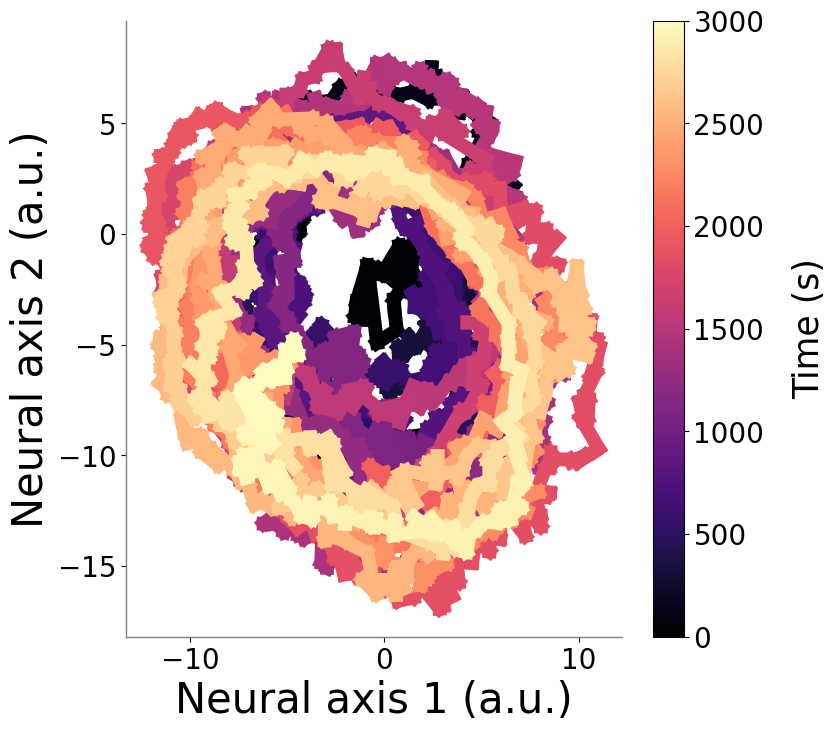

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

test_encs_best = np.load(os.path.join(res_path, 'test_enc_outputs_best.npy'))[0, :, tau_p:]

cmap = plt.get_cmap('magma')
colors = cmap(np.linspace(0, 1, test_encs_best.shape[-1]))
norm = mpl.colors.Normalize(vmin=0, vmax=test_encs_best.shape[-1] / fs)

for t in range(test_encs_best.shape[-1] - 1):
    ax.plot([test_encs_best[1, t], test_encs_best[1, t+1]], [test_encs_best[0, t], test_encs_best[0, t+1]], color=colors[t], linewidth=10)

ax.grid(False)

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Time (s)', fontsize=25, labelpad=20)
cbar.ax.set_yticks(np.arange(0, 3500, 500))

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Neural axis 1 (a.u.)', fontsize=30)
ax.set_ylabel('Neural axis 2 (a.u.)', fontsize=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines["left"].set_color('grey')
ax.spines["bottom"].set_color('grey')
ax.spines["left"].set_linewidth(1)

ax.spines["bottom"].set_linewidth(1)


This suggests the activity of this population oscillates over time - can we recover the phase of the oscillations from this representation? 
To try and do so, we obtain the current centre of the ring as the average position of the embeddings over the last ~50s, which is relevant to the time-scale of the oscillations.
Then, we compute the angle between a segment that connects the centre of the ring to the current embedding, and a horizontal segment starting from the current embedding.
The functions below do all of these things.

In [11]:
import math

def calculate_angle(segment1, segment2):
    """
    Calculate the angle in degrees between two segments
    Args:
        segment1: 
        segment2: 

    Returns:

    """
    # Convert the segments into vectors
    vec1 = (segment1[1][0] - segment1[0][0], segment1[1][1] - segment1[0][1])
    vec2 = (segment2[1][0] - segment2[0][0], segment2[1][1] - segment2[0][1])

    # Calculate the dot product
    dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]

    # Calculate the magnitudes of the vectors
    mag_vec1 = math.sqrt(vec1[0]**2 + vec1[1]**2)
    mag_vec2 = math.sqrt(vec2[0]**2 + vec2[1]**2)

    # Calculate the cosine of the angle using the dot product and the magnitudes
    cos_angle = dot_product / (mag_vec1 * mag_vec2)

    # Use the arccos function to find the angle in radians, then convert it to degrees
    angle = math.degrees(math.acos(cos_angle))
    
    return angle


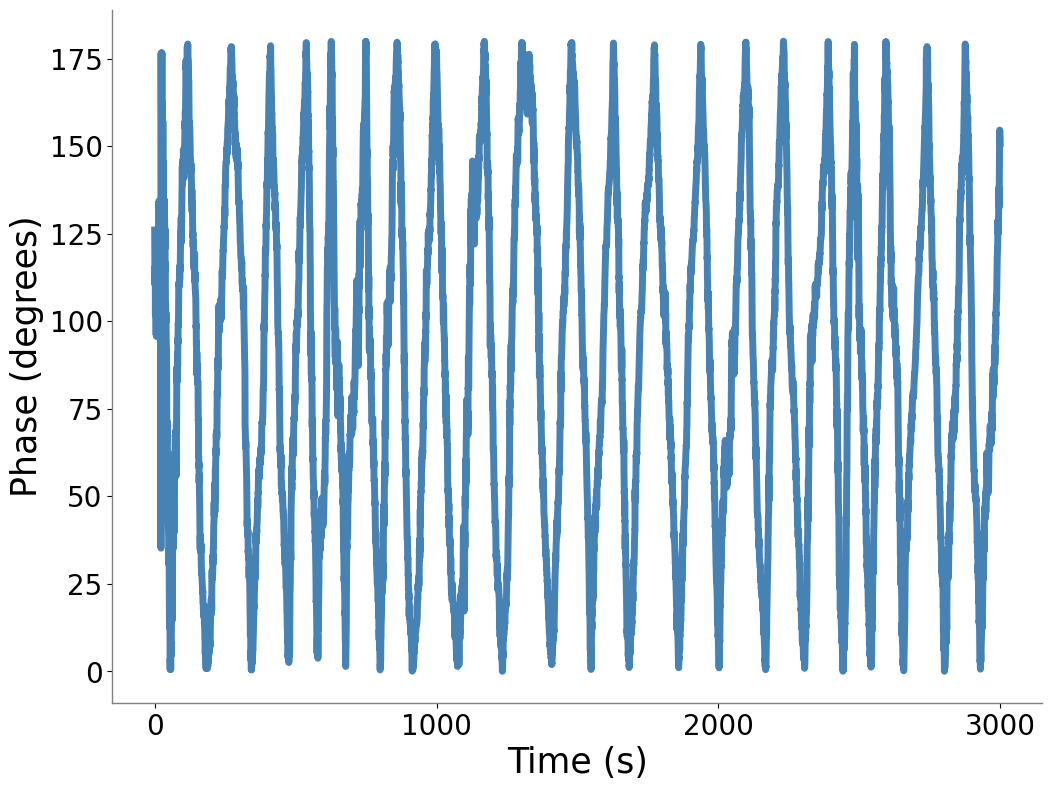

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

phi_t = []
window = 200

for t in range(test_encs_best.shape[-1]):
    segment1 = (test_encs_best[..., t], [test_encs_best[0, t] + 10, test_encs_best[1, t]])
    segment2 = (test_encs_best[..., t], np.mean(test_encs_best[..., max(0, t-window):max(t, window)], axis=-1))
    phi_t.append(calculate_angle(segment1, segment2))
phi_t = np.array(phi_t)

ax.plot(phi_t, linewidth=5, color='steelblue')
ax.set_ylabel('Phase (degrees)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.grid(False)
T = phi_t.shape[-1] / fs
ax.set_xticks(np.arange(0, int(phi_t.shape[-1] + phi_t.shape[-1] / 3), phi_t.shape[-1] / 3))
ax.set_xticklabels(np.arange(0, T + T / 3, T / 3).astype(int), fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines["left"].set_color('grey')
ax.spines["bottom"].set_color('grey')
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.tick_params(axis='both', which='major', labelsize=20, left=True, bottom=True)

By sorting the neurons based on the peak of their correlation with this signal, we see the oscillations directly emerge in the neuronal responses!

In [13]:
def sort_with_sparks(spikes, phase, maxlag):
    """"

    Sorts the spikes based on their correlation with the phase signal
    Args:
        spikes: ndarray of shape (n_neurons, n_timepoints)
        phase: phase signal of shape (n_timepoints,)
        maxlag: maximum lag to consider
        
        Returns: ndarray of shape (n_neurons,) with the indices of the sorted neurons
        
    """
    corr_vec = np.zeros(spikes.shape[0])
    for i in range(spikes.shape[0]):
        val = correlate(spikes[i], phase, mode='full')
        time = correlation_lags(len(spikes[i]), len(phase), mode='full')
        idx = np.argmax(val[np.abs(time) < maxlag])
        v = val[np.abs(time) < maxlag][idx]
        t = time[np.abs(time) < maxlag][idx]

        if t >= 0:
            corr_vec[i] = v
        else:
            corr_vec[i] = -v
    
    return np.argsort(corr_vec)

def spikes_downsample(spikes, downsampling_factor, mode='mean'):
    """
    Downsamples the spikes by binning them
    
    Args:
        spikes:  ndarray of shape (n_neurons, n_timepoints)
        downsampling_factor:  int, factor by which to downsample
        mode: 'mean' or 'max', whether to take the mean or the max in each bin

    Returns: ndarray of shape (n_neurons, n_timepoints // downsampling_factor)
    """
    bins = np.arange(0, spikes.shape[-1] + downsampling_factor, downsampling_factor)
    spike_times = spikes * np.arange(spikes.shape[-1])[None, :]
    if mode == 'mean':
        return np.vstack([(np.histogram(spike_times_unit[spike_times_unit != 0], bins)[0] / downsampling_factor)[None, :] for spike_times_unit in spike_times]).astype(float)
    elif mode == 'max':
        return np.vstack([(np.histogram(spike_times_unit[spike_times_unit != 0], bins)[0] > 0)[None, :] for spike_times_unit in spike_times]).astype(float)


Text(0.5, 0, 'Time (s)')

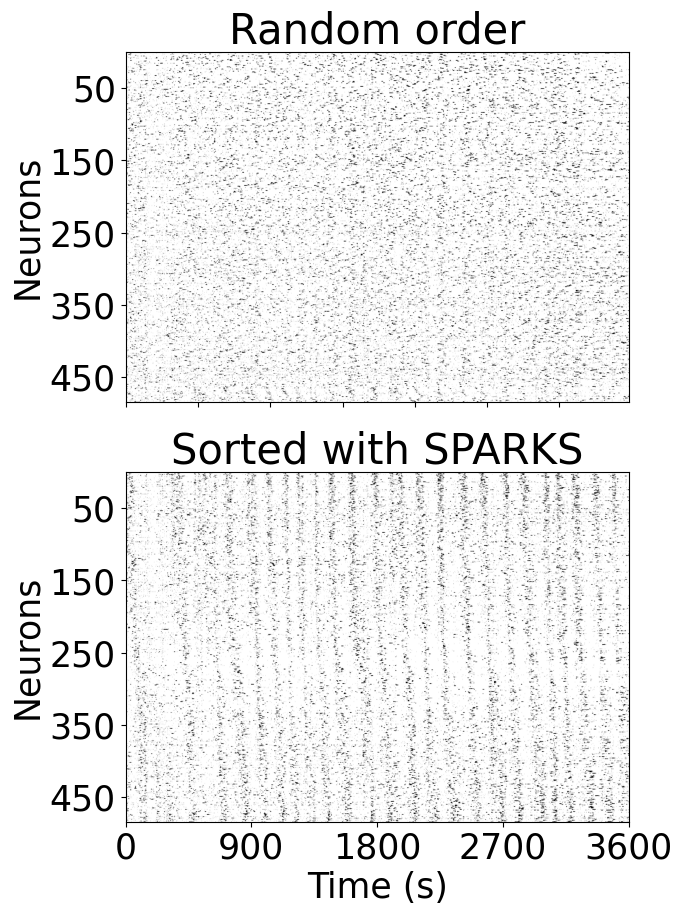

In [14]:
from scipy.signal import welch

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
window_size = 8192 // 4 # 17.6 min
overlap = window_size // 2  # 50% overlap
plt.rcParams['svg.fonttype'] = 'none'

downsampling_factor = 4
fs = fs_120 / downsampling_factor
spikes_downsampled = spikes_downsample(spikes, downsampling_factor, mode='max')

repeats = 10
axs[0].imshow(np.repeat(spikes_downsampled, repeats, 0), cmap='Greys')
axs[0].set_title('Random order', fontsize=30)
axs[0].grid(False)

maxlag = 10
sorting_sparks = sort_with_sparks(spikes_downsampled[:, int(600 * fs):], phi_t, maxlag * 2)
axs[1].imshow(np.flip(np.repeat(spikes_downsampled[sorting_sparks], repeats, 0), axis=0), cmap='Greys')
axs[1].set_title('Sorted with SPARKS', fontsize=30)
axs[1].grid(False)

for ax in axs:
    ax.grid(False)
    ax.set_yticks(np.arange(50 * 10, 550 * 10, 100 * 10))
    ax.set_yticklabels(np.arange(50, 550, 100), fontsize=25)
    ax.set_ylabel('Neurons', fontsize=25)


T = spikes_downsampled.shape[-1] / fs
axs[0].tick_params(axis='x', which='major', labelbottom=False)
axs[1].set_xticks(np.arange(0, int(spikes_downsampled.shape[-1] + spikes_downsampled.shape[-1] / 4), spikes_downsampled.shape[-1] / 4))
axs[1].set_xticklabels(np.arange(0, T + T / 4, T / 4).astype(int), fontsize=25)
axs[1].set_xlabel('Time (s)', fontsize=25)

In [16]:
!jupyter nbconvert --to html demo_mec.ipynb

[NbConvertApp] Converting notebook demo_mec.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 1970440 bytes to demo_mec.html
